<a href="https://colab.research.google.com/github/yingzibu/PBPK/blob/main/EDNE_T2_SE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# paper: Hoffelder et al. (2015). Multivariate equivalence tests for use in pharmaceutical development

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import math
from scipy.stats import norm
import warnings
from tqdm import tqdm
warnings.simplefilter(action='ignore', category=FutureWarning)
# !pip install latexify-py==0.3.1 --quiet
# import latexify

### jackknife technique to calculate bias-corrected and accelerated (BCa) intervals

`from scipy.stats import norm`

$\phi$:
`norm.cdf(num)`

$\phi^{-1}$:
`norm.ppf(num)`

In [ ]:
from scipy.stats import norm

print(f'if alpha=0.5, norm.ppf(alpha) = 0')
norm.ppf(0.95),norm.cdf(norm.ppf(0.95)), norm.ppf(0.5)

if alpha=0.5, norm.ppf(alpha) = 0


(1.6448536269514722, 0.95, 0.0)

## The EDNE test for equivalence

Using as a measure of dissimilarity of the two distributions, the *Euclidean Distance of the Nonstandardized Expected (EDNE)* values as formally being defined by

\begin{equation}
\delta^2_{\text{EDNE}} := ||\mu_1 - \mu_2||^2 = (\mu_1 - \mu_2)^\top (\mu_1 - \mu_2) = \sum_{t=1}^p (\mu_{1i} - \mu_{2i})^2
\end{equation}

the testing problem to be considered next reads

$$H_0 \delta^2_{\text{EDNE}} \geq \Delta^2_{\text{EDNE}}$$ versus

$$H_A \delta^2_{\text{EDNE}} < \Delta^2_{\text{EDNE}}$$


where the equivalence margin $\Delta^2_{\text{EDNE}}$ determines the width of the respective equivalence region. In contrast to the $T^2$-test, the EDNE-test does not rely on the assumption of equal covariance structures, since the target parameter to which the hypotheses relate, involves only the two vectors of population means

$$T_{\text{ENDE}} = \frac{(\overline{X} - \overline{Y})^\top (\overline{X} - \overline{Y}) - \Delta^2_{\text{EDNE}}}{\sqrt{4(\overline{X} - \overline{Y})^\top (\frac{S_1}{m} + \frac{S_2}{n})(\overline{X} - \overline{Y})}}$$

The large-sample test obtained in this way rejects $H_0$ in favor of equivalence if it turns out that there holds $T_EDNE < C=\phi^{-1} (\alpha)$, where $\phi^{-1} (\alpha)$ denotes the lower $\alpha$-quantile of the standard normal distribution.

Default: $\Delta^2_{\text{EDNE}}:= p \cdot 99$

In [ ]:
def cal_EDNE(ref_df, test_df, alpha_=0.05, delta_square=None):
    if delta_square == None: delta_square = 99 * len(ref_df.columns)

    ref_mean = ref_df.mean(axis=0)
    test_mean = test_df.mean(axis=0)
    diff = ref_mean - test_mean

    ref_s = ref_df.cov()
    test_s = test_df.cov()

    m = len(ref_df); n = len(test_df)
    assert m == n

    s_pool = ref_s / m + test_s / n
    u_ = norm.ppf(alpha_)

    t_up = diff.T@ diff - delta_square
    t_down = np.sqrt(4 * diff.T @ s_pool @ diff)
    t_EDNE = t_up / t_down
    if t_EDNE < u_: relation_ = '<'; conc = 'similar'
    else: relation_ = '>='; conc = 'dissimilar'
    # print('T_EDNE    critical value     conclusion')
    # print(f'{t_EDNE:.3f} {relation_} [u_{alpha_}] = {u_:.3f}    {conc}')


    temp_ = {}
    temp_['EDNE Test'] = [f'| T_EDNE = {t_EDNE:.3f}',
                         relation_,
                         f'[u_{alpha_}] = {u_:.3f}', conc]
    temp_df = pd.DataFrame.from_dict(temp_, orient='index',
            columns=['Test statistic', 'vs', 'critical value', 'conclusion'])
    print(temp_df)
    return t_EDNE


# cal_EDNE(ref_df, test_df)

## The $T^2$-test for equivalence

In the $T^2$ test, the Mahalanobis distance $\delta_{\text{HOT}}^2 = (\mu_1 - \mu_2)^\top \Sigma^{-1}(\mu_1 - \mu_2)$ is chosen as measure of dissimilarity of the two distributions under comparison. The distributions are considered to be equivalent, if their Mahalanobis distance is sufficiently small

More precisely speaking, the hypotheses of the $T^2$-test are

$$H_0: \delta_{\text{HOT}}^2 \geq \Delta_{\text{HOT}}^2$$

versus

$$H_A: \delta_{\text{HOT}}^2 < \Delta_{\text{HOT}}^2$$

An exact optimum test for this is based on Hotelling's $T^2$-statistic which is defined by:

\begin{equation}
T^2 = \frac{mn}{m+n}(\overline{X} - \overline{Y})^\top S^{-1} (\overline{X} - \overline{Y})
\end{equation}

The null hypothesis $H_0$ has to be rejected if $T^2 < C$, where

$$C = \frac{(N-2)p}{N-1-p} F_{p, N-1-p;\alpha} (\frac{mn \Delta^2_{\text{HOT}}}{N}), N = m + n$$


$F_{p, N-1-p;\alpha} (\frac{mn \Delta^2_{\text{HOT}}}{N})$ denotes the lower quantile of the noncentral F-distribution with p and $N-1-p$ degrees of freedom and noncentrality parameter $\frac{mn \Delta^2_{\text{HOT}}}{N}$, default $\Delta^2_{\text{HOT}} = 0.74^2$




In [ ]:
def cal_T_square(ref_df, test_df, alpha_=0.05, delta_square=None):
    if delta_square == None: delta_square = 0.74 ** 2

    ref_mean = ref_df.mean(axis=0)
    test_mean = test_df.mean(axis=0)
    diff = ref_mean - test_mean

    ref_s = ref_df.cov()
    test_s = test_df.cov()

    m = len(ref_df); n = len(test_df)
    assert m == n
    N = m + n
    P = len(ref_df.columns)


    s = (ref_s + test_s) / 2
    s_inv = np.linalg.inv(s)
    t_square = m * n / N * diff.T @ s_inv @ diff

    # Fcrit = scipy.stats.f.ppf(dfn=P, q=alpha_, dfd=N-P-1) previous
    # yet here we have noncentrality parameter, should use ncf function and param nc
    nc = delta_square * m * n / N
    Fcrit = scipy.stats.ncf.ppf(q=alpha_, dfn=P, dfd=N-P-1, nc=nc, loc=0, scale=1)
    adjusted_t_square = (N - 1 - P) / (N - 2) / P * t_square
    # C_ = (N-2) * P / (N - 1 - P) * Fcrit
    if adjusted_t_square < Fcrit: relation_ = '<'; conc = 'similar'
    else: relation_ = '>='; conc = 'dissimilar'

    temp_ = {}
    temp_['T^2-test'] = [f'| param*T2 = {adjusted_t_square:.3f}',
                         relation_,
                         f'[F_{alpha_}] = {Fcrit:.3f}', conc]
    temp_df = pd.DataFrame.from_dict(temp_, orient='index',
            columns=['Test statistic', 'vs', 'critical value', 'conclusion'])
    print(temp_df)
    # print(f'test statistic    critical value    conclusion')
    # print(f'(N-p-1)/[p(N-2)] T^2 =  {adjusted_t_square:.3f}     {relation_}[F_{alpha_}] = {Fcrit:.3f}   {conc}')
    return adjusted_t_square
    # try:
    #     import latexify
    #     @latexify.function(use_math_symbols=True)
    #     def C(Fcrit, P, N):
    #         # small = p, N-1-p;alpha
    #         return (N-2) * P / (N - 1 - P) * Fcrit
    #     display(C)

    # except: pass
    # print(f'T^2      C       critical value    conclusion')
    # print(f'{t_square:.3f} {relation_} {C_:.3f} | [F_{alpha_}] = {Fcrit:.3f}   {conc}')
    # return t_square

# cal_T_square(ref_df, test_df)

## The SE-Test for Equivalence

In contrat to the EDNE-test, the difference between the population means are now to be assessed as scaled quantities, forming ratios over the variabilities in each vaiable. Choose

$$\delta^2_{\text{SE}} = \sum_{i=1}^P\frac{ (\mu_{1i}-\mu_{2i} )^2}{\frac{1}{2} (\sigma_{ii}^{(1)}+\sigma_{ii}^{(2)})}$$

as the measure of dissimilarity of the two distributions under comparison, implies that main interest is in the *Standardized Differences of the Expected (SE)* values.


\begin{equation}
T_{\text{SE}} = \frac{\sum_{i=1}^p \frac{ (\overline{X}_{i}-\overline{Y}_{i} )^2}{\frac{1}{2} (S_{ii}^{(1)}+S_{ii}^{(2)})} - \Delta^2_{\text{SE}}   }{\sqrt{ 16 \hat{\delta^*}^\top  (S_1/m + S_2/n) \hat{\delta^*} + 4 \hat{\epsilon^*}^\top (\hat{\Pi}_1/m + \hat{\Pi}_2/n) \hat{\epsilon^*}       }}
\end{equation}

where

$\hat{\delta^*} = \begin{bmatrix}
\frac{\overline{X}_1 - \overline{Y}_1}{S_{11}^{(1)}+S_{11}^{(2)}} \\
\vdots \\
\frac{\overline{X}_p - \overline{Y}_p}{S_{pp}^{(1)}+S_{pp}^{(2)}} \end{bmatrix}$



$\hat{\epsilon^*} = \begin{bmatrix}
\left(\frac{\overline{X}_1 - \overline{Y}_1}{S_{11}^{(1)}+S_{11}^{(2)}} \right)^2 \\
\vdots \\
\left(\frac{\overline{X}_p - \overline{Y}_p}{S_{pp}^{(1)}+S_{pp}^{(2)}} \right)^2 \end{bmatrix}$



$\hat{\Pi}_1 = 2 \begin{bmatrix}
 (S_{11}^{(1)} )^2 & \cdots & (S_{1p}^{(1)} )^2 \\
 \vdots & \ddots & \vdots \\
 (S_{p1}^{(1)} )^2 & \cdots & (S_{pp}^{(1)} )^2
\end{bmatrix}$

Similarly for $\hat{\Pi}_2$

$S_{ij}^{(1)} $ is the entry in the ith row and jth column of empirical covariance matrix $S_1$. Similarly for $S_{11}^{(2)} $ and $S_2$.

In [ ]:
def cal_SE(ref_df, test_df, alpha_=0.05, delta_square=None):
    if delta_square == None: delta_square = 0.74 ** 2

    ref_mean = ref_df.mean(axis=0)
    test_mean = test_df.mean(axis=0)
    diff = (ref_mean - test_mean)

    ref_s = ref_df.cov()
    test_s = test_df.cov()

    m = len(ref_df); n = len(test_df)
    assert m == n
    N = m + n
    P = len(ref_df.columns)

    s_list = [ref_s.iloc[i,i] + test_s.iloc[i,i] for i in range(P)]
    hat_delta = diff.div(pd.Series(s_list, index=ref_df.columns), axis=0)
    hat_epsilon = np.multiply(hat_delta, hat_delta)

    t_up = 2 * hat_delta.T @ diff - delta_square
    s_pool = (ref_s/m + test_s/n)

    t_down = 16 * hat_delta.T @ s_pool @ hat_delta
    hat_pi_1 = 2 * np.multiply(ref_s, ref_s)
    hat_pi_2 = 2 * np.multiply(test_s, test_s)
    t_down += 4 * hat_epsilon.T @ (hat_pi_1 / m + hat_pi_2 / n) @ hat_epsilon
    t_se = t_up / np.sqrt(t_down)

    u_ = norm.ppf(alpha_)
    if t_se < u_: relation_ = '<'; conc = 'similar'
    else: relation_ = '>='; conc = 'dissimilar'

    temp_ = {}
    temp_['SE Test'] = [f'| T_SE = {t_se:.3f}',
                         relation_,
                         f'[u_{alpha_}] = {u_:.3f}', conc]
    temp_df = pd.DataFrame.from_dict(temp_, orient='index',
            columns=['Test statistic', 'vs', 'critical value', 'conclusion'])
    print(temp_df)
    return t_se

# cal_SE(ref_df, test_df), cal_SE(ref_df[[15,20]], test_df[[15,20]])

## The GMD test for equivalence

As a further modification, the *Generalized Mahalanobis Distance (GMD)*

$\delta^2_{\text{GMD}} = (\mu_1 - \mu_2)^\top [\frac{1}{2} (\Sigma_1 + \Sigma_2)]^{-1}(\mu_1 - \mu_2) = 2(\mu_1 - \mu_2)^\top [(\Sigma_1 + \Sigma_2)]^{-1}(\mu_1 - \mu_2) $

can be considered as measure of dissmilarity of two multivariate Gaussian distributions with arbitrary covariance matrices. It leads to formulating the hypotheses

$H_0: \delta^2_{\text{GMD}} \leq \Delta^2_{\text{GMD}}$ versus $H_A: \delta^2_{\text{GMD}} < \Delta^2_{\text{GMD}}$

Unlike the EDNE-test and the SE-test, the distance measure to be used in GMD-test involves the entire covariance structure of the data, including the correlations of the $p$ variables. The resulting GMD test statistic is given by



$$T_{\text{GMD}} = \frac{\sqrt{N} \left(  2(\overline{X}-\overline{Y})^\top (S_1 + S_2)^{-1} (\overline{X}-\overline{Y}) - \Delta^2_{\text{GMD}}      \right)  }{ \sqrt{\hat{v}}}$$

where
\begin{align}
\hat{v} & = 16 \hat{\gamma}^\top \left(\frac{N}{m}S_1 + \frac{N}{n}S_2  \right) \hat{\gamma} \\
& + \frac{4N}{m}\sum_{i=1}^p \sum_{j=1}^p \sum_{k=1}^p \sum_{l=1}^p \left(
  S_{ik}^{(1)} S_{jl}^{(1)}  +  S_{il}^{(1)}  S_{jk}^{(1)}  \right) \hat{\gamma}^\top E_{ij}\hat{\gamma}  \hat{\gamma}^\top E_{kl}\hat{\gamma} \\
& + \frac{4N}{n}\sum_{i=1}^p \sum_{j=1}^p \sum_{k=1}^p \sum_{l=1}^p \left(
  S_{ik}^{(2)} S_{jl}^{(2)}  +  S_{il}^{(2)}  S_{jk}^{(2)}  \right) \hat{\gamma}^\top E_{ij}\hat{\gamma}  \hat{\gamma}^\top E_{kl}\hat{\gamma}
\end{align}
and
$$\hat{\gamma} := (S_1 + S_2)^{-1} (\overline{X}-\overline{Y})$$

$E_{ij}$ stands for the (i,j)th ($p \times p$) unit matrix, i.e., the matrix, which carries the item 1 in the $i$th row and in the $j$th column where all other entries are 0.

The GMD-test rejects $H_0$ in favor of equivalence if it turns out that $T_{\text{GMD}} < C := \phi^{-1}_{\alpha}$, where, as before, $\phi^{-1}_{\alpha}$ stands for the lower $\alpha$-quantile of the standard normal distribution

In [ ]:
def cal_GMD(ref_df, test_df, alpha_=0.05, delta_square=None):
    if delta_square == None: delta_square = 0.74 ** 2

    ref_mean = ref_df.mean(axis=0)
    test_mean = test_df.mean(axis=0)
    diff = (ref_mean - test_mean)

    ref_s = ref_df.cov()
    test_s = test_df.cov()

    m = len(ref_df); n = len(test_df)
    assert m == n
    N = m + n
    P = len(ref_df.columns)
    s_inv = np.linalg.inv(ref_s + test_s)
    hat_gamma = s_inv @ diff

    t_up = np.sqrt(N) * (2 * diff.T @ hat_gamma - delta_square)

    hat_v = 16 * hat_gamma @ (N/m * ref_s + N/n * test_s) @ hat_gamma
    total_sum = 0
    for i in range(P):
        for j in range(P):
            for k in range(P):
                for l in range(P):
                    total_sum += 4 * N / m * (
    ref_s.iloc[i,k] * ref_s.iloc[j,l] + ref_s.iloc[i,l] * ref_s.iloc[j,k]
                ) * hat_gamma[i] * hat_gamma[j] * hat_gamma[k] * hat_gamma[l]

                    total_sum += 4 * N / n * (
    test_s.iloc[i,k] * test_s.iloc[j,l] + test_s.iloc[i,l] * test_s.iloc[j,k]
            ) * hat_gamma[i] * hat_gamma[j] * hat_gamma[k] * hat_gamma[l]
    hat_v += total_sum
    t_gmd = t_up / np.sqrt(hat_v)
    t_gmd
    u_ = norm.ppf(alpha_)
    if t_gmd < u_: relation_ = '<'; conc = 'similar'
    else: relation_ = '>='; conc = 'dissimilar'

    temp_ = {}
    temp_['GMD Test'] = [f'| T_GMD = {t_gmd:.3f}',
                        relation_,
                        f'[u_{alpha_}] = {u_:.3f}', conc]
    temp_df = pd.DataFrame.from_dict(temp_, orient='index',
            columns=['Test statistic', 'vs', 'critical value', 'conclusion'])
    print(temp_df)
    return t_gmd



## Table 1

In [ ]:
## Table 1
ref_df = pd.DataFrame()
ref_df[15] = pd.DataFrame([49,15,56,57,6,62,23,11,9,42,57,4])
ref_df[20] = pd.DataFrame([86,59,84,87,58,90,71,64,61,81,86,48])
ref_df[25] = pd.DataFrame([98,96,96,99,90,97,97,92,88,96,98,82])

test_df = pd.DataFrame()
test_df[15] = pd.DataFrame([31,13,55,50,37,47,39,3,37,34,4,11])
test_df[20] = pd.DataFrame([79,64,81,72,91,88,87,33,77,74,59,60])
test_df[25] = pd.DataFrame([94,97,96,86,99,96,97,80,94,92,91,100])
ref_df, test_df

(    15  20  25
 0   49  86  98
 1   15  59  96
 2   56  84  96
 3   57  87  99
 4    6  58  90
 5   62  90  97
 6   23  71  97
 7   11  64  92
 8    9  61  88
 9   42  81  96
 10  57  86  98
 11   4  48  82,
     15  20   25
 0   31  79   94
 1   13  64   97
 2   55  81   96
 3   50  72   86
 4   37  91   99
 5   47  88   96
 6   39  87   97
 7    3  33   80
 8   37  77   94
 9   34  74   92
 10   4  59   91
 11  11  60  100)

### F. Bias correction

The estimation bias is contributed by the term $\sum_{i=1}^P \frac{\sigma_{ti}^2 + \sigma_{ri}^2}{n}$ within the log function. An intuitive bias correction would lead to subtracting the unbiased estimate of $\sum_{i=1}^P \frac{\sigma_{ti}^2 + \sigma_{ri}^2}{n}$ within f$_2$ and we have the following unbiased estimate

\begin{align}
\hat{f_2}^* &= 50 \log_{10} \frac{100}{\sqrt{1 + \frac{1}{P} \left[\sum_{i=1}^P  (\overline{x_{ti}} - \overline{x_{ri}} )^2 - \sum_{i=1}^P \frac{s^2_{ti}+s^2_{ri}}{n}    \right]}} \\
&= 100 - 25 \log_{10} \left\{1 + \frac{1}{P} \left[\sum_{i=1}^P  (\overline{x_{ti}} - \overline{x_{ri}} )^2 - \sum_{i=1}^P \frac{s^2_{ti}+s^2_{ri}}{n} \right] \right\}
\end{align}


where $s^2_{ti}$ and $s^2_{ri}$ are the unbiased estimates of variance at the $i-$th time point of the test and reference batches respectively. The confidence interval is then adjusted accordingly. For the five test batches in example #2 the bias adjusted estimates are given in Table 7. It is shown in Table 7 that for the five comparisons, the bias adjusted estimates of f$_2$ are not much different to the biased estimate $\hat{f_2}$ because of the small dissolution variance of the six (one reference and five test) batches.

However, **the adjustment is not valid when** $\sum_{i=1}^P  (\overline{x_{ti}} - \overline{x_{ri}} )^2 < \sum_{i=1}^P \frac{s^2_{ti}+s^2_{ri}}{n}$

In [ ]:
def cal_f2(ref_df, test_df, bc=False, vc=False, ver=False): # implement bias corrected
    # input is df, could do bc vc
    if type(ref_df) == pd.DataFrame: ref_mean = list(ref_df.mean(axis=0))
    # input is a list of mean, cannot do vc, bias corrected
    elif type(ref_df) == list:       ref_mean = ref_df; bc, vc=False, False
    else: print('unrecognized for ref data, type={type(ref_df)}'); return

    if type(test_df) == pd.DataFrame: test_mean = list(test_df.mean(axis=0))
    elif type(test_df) == list:       test_mean = test_df; bc, vc=False, False
    else: print('unrecognized for ref data, type={type(test_df)}'); return

    P = len(ref_mean) # number of time points
    assert len(ref_mean) == len(test_mean)
    sum_diff_square = 0
    for i, j in zip(ref_mean, test_mean):
        sum_diff_square += (i-j) ** 2

    sum_variance = 0
    if vc or bc: # will apply var or bias corrected only inf ref and test are dataframes
        try: assert len(ref_df) == len(test_df)
        except: print('Different unit number between ref and test'); return

        ref_S = [i**2 for i in np.std(ref_df, ddof=1).tolist()]
        test_S= [i**2 for i in np.std(test_df, ddof=1).tolist()]
        if bc and vc == False:
            sum_variance =  np.sum(ref_S) + np.sum(test_S)
        if vc: # apply variance-corrected f2
            bc = True
            sum_variance = 0
            for rs, ts in zip(ref_S, test_S):
                sum_s = rs + ts
                w_t = 0.5 + ts / sum_s
                w_r = 0.5 + rs / sum_s
                sum_variance += w_t * ts + w_r * rs
        n = len(ref_df)   # number of units
        sum_variance /= n

    if sum_variance > sum_diff_square: # definitely applied bc or vc
        if vc: param_name = 'vc'; vc = False
        else: param_name = 'bc' ; bc = False

        print(f'var    >   sum(|t-r|^2), cannot apply {param_name}')
        print(f'{sum_variance:.3f} > {sum_diff_square:.3f}')
        sum_variance = 0
    # else: # 2 conditions, sum_variance=0, sum_variance \in (0, sum_diff_square)

        # reset bc = False, vc = Fal

    D = sum_diff_square - sum_variance

    f2 = 100 - 25 * np.log10(1+D/P)
    if ver: print(f'F2 value R & T: {f2:.3f} | bc: {bc} | vc: {vc}')
    # if ver: return f2, sum_variance, sum_diff_square
    return f2


def cal_MSD(ref_df, test_df, tolerance_list=[10,11,13,15]):
    try:
        assert list(test_df.columns) == list(ref_df.columns)
    except:
        print(f'time diff: test{list(test_df.columns)} ref {list(ref_df.columns)}')
        return
    time_points = list(test_df.columns)

    P = len(time_points)
    n = len(ref_df)

    try: assert n == len(test_df)
    except:
        print(f'ref units {n} are different from test units {len(test_df)}')
        print('Check data before cal MSD'); return

    S1 = ref_df.cov()
    S2 = test_df.cov()
    S_pooled = (S1 + S2) / 2
    ref_mean = list(ref_df.mean(axis=0))
    test_mean = list(test_df.mean(axis=0))
    x2_x1 = [i-j for i, j in zip(test_mean, ref_mean)]
    a = np.array(x2_x1).reshape(len(time_points), 1)
    K = n**2/(2*n)* (2*n - P - 1) / ((2*n - 2) * P)
    Fcrit = scipy.stats.f.ppf(q=1-.1, dfn=P, dfd=2*n-P-1)
    spinv = np.linalg.inv(S_pooled.loc[time_points, time_points])
    D_M = np.sqrt(a.T @ spinv @ a)[0][0]
    print('Mahalanobis distance (T & R):', D_M)

    bound1 = a @ (1 + np.sqrt(Fcrit/(K * a.T @ spinv @ a)))
    bound2 = a @ (1 - np.sqrt(Fcrit/(K * a.T @ spinv @ a)))
    # 90% CI of Mahalanobis distance:
    DM_1 = np.sqrt(bound1.T @ spinv @ bound1)[0][0]
    DM_2 = np.sqrt(bound2.T @ spinv @ bound2)[0][0]
    DM_upper = max(DM_1, DM_2)
    DM_lower = min(DM_1, DM_2)

    print('lower bound of DM:', DM_lower)
    print('upper bound of DM:', DM_upper)


    print('DM_upper | tolerance limit | conclusion')
    for tolerance in tolerance_list:

        D_g = np.array([tolerance] * len(time_points)).reshape(len(time_points), 1)
        RD = np.sqrt(D_g.T @ spinv @ D_g)[0][0]

        if DM_upper <= RD:
            print(f'{DM_upper:.3f} \t <=  {RD:.3f}[{tolerance}%]     Similar')
        else:
            print(f'{DM_upper:.3f} \t >   {RD:.3f} [{tolerance}%]    Dissimilar')

Jackknife statistic does not change with bootstrap as this is calculated using the original ref and test by omitting observations. From R reference bootf2:

"
For any sample with size $n$, the jackknife estimator is obtained by estimating the parameter for each subsample omitting the $i$th observation. When 2 samples (e.g. test and reference) are invovled, there are several possible ways to do it. Assuming sample size of test and reference are $n_T$ and $n_R$:

* Estimated by removing one observation from both test and reference samples. In this case, the prerequisite is $n_T == n_R$, denoted by `nt=nr` in the function. Will have $n_T$ jackknife estimators.

* Estimate the jackknife for test sample while keeping the reference data unchanged, and then estimate jackknife for reference sample while keeping the test sample unchanged. This is denoted by `nt+nr` in the function. **Default** method. Will have $n_T + n_R$ jackknife estimators.

* For each observation deleted from test sample, estimate jackkinfe for reference sample. This is denoted by `nt*nr` in the function. Will have $n_T * n_R$ jackknife estimators.


"

In [ ]:
def jackknife_statistic(ref_df, test_df, type_jk='nt=nr'):
    nt = len(test_df)
    nr = len(ref_df)
    jk_list = []
    if type_jk == 'nt=nr':
        assert nt == nr
        for i in range(nt):
            t = test_df.drop(i)
            r = ref_df.drop(i)
            f2 = cal_f2(t, r)
            jk_list.append(f2)
    elif type_jk == 'nt+nr':
        for i in range(nt):
            t = test_df.drop(i)
            f2 = cal_f2(t, ref_df)
            jk_list.append(f2)

        for i in range(nr):
            r = ref_df.drop(i)
            f2 = cal_f2(test_df, r)
            jk_list.append(f2)
    elif type_jk == 'nt*nr':
        for i in range(nt):
            t = test_df.drop(i)
            for j in range(nr):
                r = ref_df.drop(j)
                f2 = cal_f2(t, r)
                jk_list.append(f2)

    else:
        print("""type_jk should be one of['nt+nr', 'nt*nr', 'nt=nr']""")
        return
    return jk_list

Using Jackknife technique to estimate $\hat{z_0}$ and $\hat{a}$

$$\hat{a} = \frac{\sum_{i=1}^n (\hat{f}_{2,m} - \hat{f}_{2,i})^3}{6\left( \sum_{i=1}^n (\hat{f}_{2,m} - \hat{f}_{2,i})^2   \right)^{3/2}}$$

$\hat{f}_{2,i}$ is the $i$th jackknife statistic, $\hat{f}_{2,m}$ is the mean of the jackknife statistics. Notice that $\hat{a}$ is calculated using jackknife, is not related to the bootstrap.


$$\hat{z_0} = \phi^{-1} \left(\frac{N\{\hat{f}^*_{2,b} < \hat{f}_{2,S}\}}{B}   \right)$$

where $N\{\cdot \}$ denotes the number of element in the set (number of bootstrap f2 smaller than f2). B is the bootstrap number.

$$\alpha_1 = \phi  \left(\hat{z_0} +\frac{\hat{z_0}+\hat{z_\alpha}}{1 - \hat{a}(\hat{z_0}+\hat{z_\alpha})}\right)$$

$$\alpha_2 = \phi  \left(\hat{z_0} +\frac{\hat{z_0}+\hat{z_{1-\alpha}}}{1 - \hat{a}(\hat{z_0}+\hat{z_{1-\alpha}})}\right)$$

Then the bias-corrected and accelerated (BCa) intervals are estimated according to Efron and Tibshirani,

$$\hat{f}_{2,L} = \hat{f}^*_{2, \alpha_1}$$

$$\hat{f}_{2,U} = \hat{f}^*_{2, \alpha_2}$$

where $\hat{f}^*_{2, \alpha_1}$ and $\hat{f}^*_{2, \alpha_2}$ are the 100$\alpha_1$ th and the $100 \alpha_2$ th percentile of the resampling estimates of f2, respectively.

In [ ]:


def bootstrap_f2_list(test_df, ref_df, B=100, bc=False, vc=False, ver=False):
    n = len(ref_df)
    f2_orig = cal_f2(test_df, ref_df, bc=bc, vc=vc, ver=ver)
    f2_estimates = []
    for i in tqdm(range(B), total=B, desc=f'bootstrap {B} samples'):
        r = ref_df.sample(n=n, replace=True) # resample with replacement
        t = test_df.sample(n=n, replace=True)
        f2 = cal_f2(t,r, bc=bc, vc=vc, ver=ver)
        f2_estimates.append(f2)
    f2_estimates.sort()
    assert len(f2_estimates) == B
    return f2_estimates, f2_orig

def BCa_jk(jk_list, f2_estimates, f2_orig, alpha_=0.05):
    m = np.mean(jk_list) # mean of the jackknife statistics
    u, d = 0, 0
    for i in jk_list:
        diff = m - i
        u += diff**3
        d += diff**2
    a_hat = u / (d**1.5)
    a_hat /= 6
    f2_num = sum(i < f2_orig for i in f2_estimates)
    z0_hat = norm.ppf(f2_num/len(f2_estimates))
    z_alpha = norm.ppf(alpha_)
    z_1_alpha = norm.ppf(1-alpha_)

    def cal_alpha(z_, z0_hat=z0_hat, a_hat=a_hat):
        temp = z0_hat + z_
        temp1 = temp / (1-a_hat*temp)
        temp1 += z0_hat
        return norm.cdf(temp1)

    alpha_1 = cal_alpha(z_alpha)
    alpha_2 = cal_alpha(z_1_alpha)
    f2_L = np.percentile(np.array(f2_estimates), 100*alpha_1)
    f2_U = np.percentile(np.array(f2_estimates), 100*alpha_2)
    return m, f2_L, f2_U

def cal_bootf2(ref_df, test_df, B=1000, bc=False, vc=False, alpha_=0.05,
               type_jk='nt=nr', ver=False):
    jk_list = jackknife_statistic(ref_df, test_df, type_jk=type_jk)
    result_here = {}
    f2_estimates, f2_orig = bootstrap_f2_list(ref_df, test_df, B=B)
    bootstrap_mean = np.mean(f2_estimates)
    m, f2_L, f2_U = BCa_jk(jk_list, f2_estimates, f2_orig, alpha_=alpha_)
    f2_L_percent = np.percentile(np.array(f2_estimates), 100*alpha_)
    f2_U_percent = np.percentile(np.array(f2_estimates), 100*(1-alpha_))
    # print(m, f2_L, f2_U)
    result_here[f'Test batch'] = [f2_orig, bootstrap_mean,
                                  f2_L_percent, f2_U_percent]

    result_here[f'Test batch BCa'] = [m, bootstrap_mean, f2_L, f2_U]
    cols_here = ['sample mean', f'{B} bootstraps mean', 'CIL', 'CI_U']
    result_df = pd.DataFrame.from_dict(result_here, orient='index', columns=cols_here)
    print('\n')
    print(result_df)


In [ ]:
# jk_list does not change as bootstrap
# cal_bootf2(ref_df, test_df)

bootstrap 1000 samples: 100%|██████████| 1000/1000 [00:01<00:00, 664.43it/s]



                sample mean  1000 bootstraps mean        CIL      CI_U
Test batch        86.623217             68.364208  47.360719  90.25663
Test batch BCa    84.108026             68.364208  81.552176  98.60898


In [ ]:
class dis_data:
    def __init__(self, df, time_points=None, col_name='Time', ref_test=['Ref', 'Test']):
        if type(df) == pd.DataFrame: # input is the whole df directly
            data_df = df.copy()
            ref_df = data_df[data_df[col_name]==ref_test[0]]
            test_df = data_df[data_df[col_name]==ref_test[1]]
        elif type(df) == list: # [ref_df, test_df]
            ref_df = df[0]; test_df = df[1]
        if time_points == None:
            print('did not specify time points, will automatically select')
            time_points = []
            time_points_float = []
            for i in ref_df.columns:
                try:
                    time_num = float(i)
                    time_points.append(i)
                    time_points_float.append(time_num)
                except: pass
        print('selected time points: ', time_points)
        self.time_points = time_points
        self.time_points_float = time_points_float


        self.ref_df = ref_df[self.time_points].reset_index(drop=True)
        self.test_df = test_df[self.time_points].reset_index(drop=True)
        self.ref_mean = list(self.ref_df.mean(axis=0))
        self.test_mean = list(self.test_df.mean(axis=0))

        # when they calculate standard deviation, they use ddof=1,
        # divided by N-1 instead of N
        # calculate standard deviation for ref_df and test_df
        self.ref_sd = list(self.ref_df.std(ddof=1))
        self.test_sd = list(self.test_df.std(ddof=1))

        # calculate cv for ref and test data, cv = sd / mean at each time point
        self.ref_cv = [i/j for i, j in zip(self.ref_sd, self.ref_mean)]
        self.test_cv = [i/j for i, j in zip(self.test_sd, self.test_mean)]
        self.ref_cov = self.ref_df.cov()
        self.test_cov = self.test_df.cov()

        dict_here = {}
        dict_here['time_point'] = self.time_points
        dict_here['ref_mean']  = self.ref_mean
        dict_here['test_mean'] = self.test_mean
        dict_here['ref_cv']  = self.ref_cv
        dict_here['test_cv'] = self.test_cv
        self.stats = pd.DataFrame.from_dict(dict_here)
        self.idx_list = [i for i in range(len(self.time_points))]
        self.idx_list_rule_85 = []


    def view_data(self):
        print('*'*50)
        print(' reference data extracted:\n', self.ref_df)
        print('\n test data extracted:\n', self.test_df)
        print('\n ---> Mean and CV calculated:\n', self.stats)
        print('\n Ref covariance: \n', self.ref_cov)
        print('\n Test covariance:\n', self.test_cov)
        print('*'*50)

    def plot_data(self, xlabel='time in minutes', ylabel='% dissolved',
                  title='Mean distribution of the test and reference'):
        x_axis = self.time_points_float
        test_axis = self.test_mean
        ref_axis = self.ref_mean
        plt.plot(x_axis, test_axis, '.-', label='test batch')
        plt.plot(x_axis, ref_axis, '.-', label='ref batch')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.show()
        plt.close()

    def apply_85_rule(self, rule_85=True):
        idx_list = []
        if rule_85: # will evaluate 85% rule,
            if len(self.idx_list_rule_85) == 0: # select from scratch
                print('---> Include 1 time point of average dissolution >85% only')
                first_85_appended = False
                for idx, (i, r, t) in enumerate(
                    zip(self.time_points, self.ref_mean, self.test_mean)):
                    if r > 85 and t > 85:
                        print(f't = {i}, mean of ref {r:.3f} & test {t:.3f} > 85%',
                              end=", ")
                        if first_85_appended == False:
                            idx_list.append(idx) # will include one time point exceeding 85%,
                            print(f'preserve time {i}')
                            first_85_appended = True
                        else: print(f'delete time {i}')
                    else: idx_list.append(idx)
                self.idx_list_rule_85 = idx_list # update rule_85 index list
                print('85% rule index list updated')

            # else: #  len(self.idx_list_rule_85) > 0:
            # self.idx_list_rule_85 is not empty, do not need to cal again
            return self.idx_list_rule_85

        else: #  rule_85 == False
            # print('Did not apply 85% rule, will calculate on all data')
            # idx_list = [i for i in range(len(self.time_points))]
            return self.idx_list

    def data_apply_85(self, rule_85=True, ver_idx=False):
        idx_list = self.apply_85_rule(rule_85=rule_85)
        time_points = list(np.take(self.time_points, idx_list))
        ref_df = self.ref_df[time_points]
        test_df = self.test_df[time_points]
        if ver_idx: return time_points, ref_df, test_df, idx_list
        return time_points, ref_df, test_df


    def cal_f2(self, rule_85=True, bc=False, vc=False, ver=True):
        """
        Use of the f2 metric is allowed provided that following constraints are met:
         -    >= 3 time-points
         -    85% rule (<= 1 time point should be included with average dissolution >85%)
         -    CV <= 20% for 1st point, <=10% for other points
        """
        print('\n', '*'*25, 'F2 calculation', '*'*25)
        print('Apply 85% rule? : ', rule_85)
        time_here, ref_df, test_df, idx_list = self.data_apply_85(
                                                    rule_85=rule_85,
                                                    ver_idx=True)

        print('\nEvaluate whether f2 is suitable :')

        if len(time_here) < 3:
            print('* WARNING: time points < 3, f2 may not be suitable')
        else:
            print(f'* Satisfy criteria for f2: {len(time_here)} time points, larger than 3')

        # evaluate CV<0.2 for first time point, CV < 0.1 for other time points rule
        test_cv_here = list(np.take(self.test_cv, idx_list))
        ref_cv_here  = list(np.take(self.ref_cv,  idx_list))

        cv_cond = True
        for idx, (i, t, r) in enumerate(zip(time_here, test_cv_here, ref_cv_here)):
            if idx == 0: # check whether CV <20%
                if t > 0.2 or r > 0.2:
                    print('CV at first time point exceeds 20%, f2 may not be suitable')
                    cv_cond = False
            else:
                if t > 0.1 or r > 0.1:
                    print(f'At time {i}, CV exceeds 10%, f2 may not be suitable')
                    cv_cond = False
        if cv_cond: print('* Satisfy CV criteria for f2 calculation')
        print()
        return cal_f2(ref_df, test_df, bc=bc, vc=vc, ver=ver)


    def cal_MSD(self, rule_85=False, tolerance_list=[10,11,13,15]):
        print('\n', '*'*25, 'MSD calculation', '*'*25)
        print('Apply 85% rule? : ', rule_85)
        time_points, ref_df, test_df = self.data_apply_85(rule_85=rule_85)

        cal_MSD(ref_df, test_df, tolerance_list=tolerance_list)

    def cal_EDNE(self, rule_85=False, alpha_=0.05, delta_square=None):
        print('\n', '*'*25, 'EDNE calculation', '*'*25)
        print('Apply 85% rule? : ', rule_85)
        time_points, ref_df, test_df = self.data_apply_85(rule_85=rule_85)

        return cal_EDNE(ref_df, test_df,
                        alpha_=alpha_, delta_square=delta_square)

    def cal_T_square(self, rule_85=False, alpha_=0.05, delta_square=None):
        print('\n', '*'*25, 'T square calculation', '*'*25)
        print('Apply 85% rule? : ', rule_85)
        time_points, ref_df, test_df = self.data_apply_85(rule_85=rule_85)

        return cal_T_square(ref_df, test_df,
                        alpha_=alpha_, delta_square=delta_square)

    def cal_SE(self, rule_85=False, alpha_=0.05, delta_square=None):
        print('\n', '*'*25, 'SE calculation', '*'*25)
        print('Apply 85% rule? : ', rule_85)
        time_points, ref_df, test_df = self.data_apply_85(rule_85=rule_85)

        return cal_SE(ref_df, test_df,
                        alpha_=alpha_, delta_square=delta_square)


    def cal_GMD(self, rule_85=False, alpha_=0.05, delta_square=None):
        print('\n', '*'*25, 'GMD calculation', '*'*25)
        print('Apply 85% rule? : ', rule_85)
        time_points, ref_df, test_df = self.data_apply_85(rule_85=rule_85)

        return cal_GMD(ref_df, test_df,
                        alpha_=alpha_, delta_square=delta_square)

    def cal_bootf2(self, rule_85=False, B=1000, bc=False, vc=False, alpha_=0.05,
                    type_jk='nt=nr', ver=False):
        print('\n', '*'*20, 'f2 bootstrap calculation', '*'*20)
        print('Apply 85% rule? : ', rule_85)
        time_points, ref_df, test_df = self.data_apply_85(rule_85=rule_85)
        cal_bootf2(ref_df, test_df, B=B, bc=bc, vc=vc, alpha_=alpha_,
                   type_jk=type_jk, ver=ver)



## Table 3, time points p = 2

did not specify time points, will automatically select
selected time points:  [15, 20]
**************************************************
 reference data extracted:
     15  20
0   49  86
1   15  59
2   56  84
3   57  87
4    6  58
5   62  90
6   23  71
7   11  64
8    9  61
9   42  81
10  57  86
11   4  48

 test data extracted:
     15  20
0   31  79
1   13  64
2   55  81
3   50  72
4   37  91
5   47  88
6   39  87
7    3  33
8   37  77
9   34  74
10   4  59
11  11  60

 ---> Mean and CV calculated:
    time_point   ref_mean  test_mean    ref_cv   test_cv
0          15  32.583333  30.083333  0.711436  0.598415
1          20  72.916667  72.083333  0.197570  0.225209

 Ref covariance: 
             15          20
15  537.356061  323.780303
20  323.780303  207.537879

 Test covariance:
             15          20
15  324.083333  233.628788
20  233.628788  263.537879
**************************************************


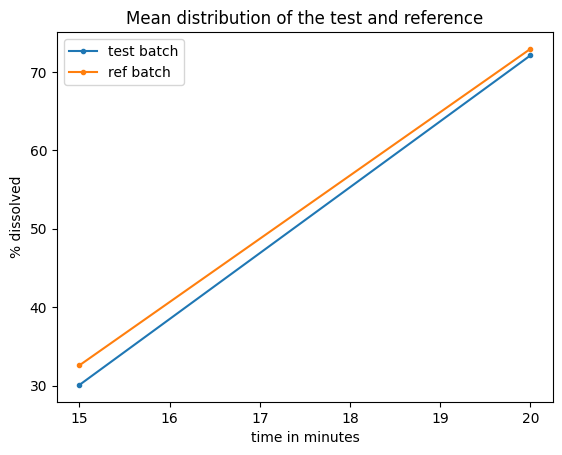


 ************************* F2 calculation *************************
Apply 85% rule? :  True
---> Include 1 time point of average dissolution >85% only
85% rule index list updated

Evaluate whether f2 is suitable :
* WARNING: time points < 3, f2 may not be suitable
CV at first time point exceeds 20%, f2 may not be suitable
At time 20, CV exceeds 10%, f2 may not be suitable

F2 value R & T: 83.737 | bc: False | vc: False

 ******************** f2 bootstrap calculation ********************
Apply 85% rule? :  False


bootstrap 1000 samples: 100%|██████████| 1000/1000 [00:00<00:00, 1205.35it/s]




                sample mean  1000 bootstraps mean        CIL       CI_U
Test batch        83.736916             65.009851  43.335052  89.915294
Test batch BCa    81.404667             65.009851  76.648883  99.622147

 ************************* MSD calculation *************************
Apply 85% rule? :  False
Mahalanobis distance (T & R): 0.16017399530305984
lower bound of DM: 0.7880116285922758
upper bound of DM: 1.1083596191983953
DM_upper | tolerance limit | conclusion
1.108 	 >   0.677 [10%]    Dissimilar

 ************************* T square calculation *************************
Apply 85% rule? :  False
              Test statistic vs    critical value conclusion
T^2-test  | param*T2 = 0.073  <  [F_0.05] = 0.241    similar

 ************************* EDNE calculation *************************
Apply 85% rule? :  False
              Test statistic vs     critical value conclusion
EDNE Test  | T_EDNE = -3.692  <  [u_0.05] = -1.645    similar

 ************************* SE calculatio

In [ ]:
### Table 3, p = 2
new_data = dis_data([ref_df[[15,20]], test_df[[15,20]]])
new_data.view_data()
new_data.plot_data()
new_data.cal_f2()
new_data.cal_bootf2()
new_data.cal_MSD(tolerance_list=[10])

new_data.cal_T_square()
new_data.cal_EDNE()
new_data.cal_SE()
new_data.cal_GMD()
print()


## Table 5, time points p = 3

did not specify time points, will automatically select
selected time points:  [15, 20, 25]
**************************************************
 reference data extracted:
     15  20  25
0   49  86  98
1   15  59  96
2   56  84  96
3   57  87  99
4    6  58  90
5   62  90  97
6   23  71  97
7   11  64  92
8    9  61  88
9   42  81  96
10  57  86  98
11   4  48  82

 test data extracted:
     15  20   25
0   31  79   94
1   13  64   97
2   55  81   96
3   50  72   86
4   37  91   99
5   47  88   96
6   39  87   97
7    3  33   80
8   37  77   94
9   34  74   92
10   4  59   91
11  11  60  100

 ---> Mean and CV calculated:
    time_point   ref_mean  test_mean    ref_cv   test_cv
0          15  32.583333  30.083333  0.711436  0.598415
1          20  72.916667  72.083333  0.197570  0.225209
2          25  94.083333  93.500000  0.054284  0.060929

 Ref covariance: 
             15          20         25
15  537.356061  323.780303  91.765152
20  323.780303  207.537879  61.734848
25   91.76515

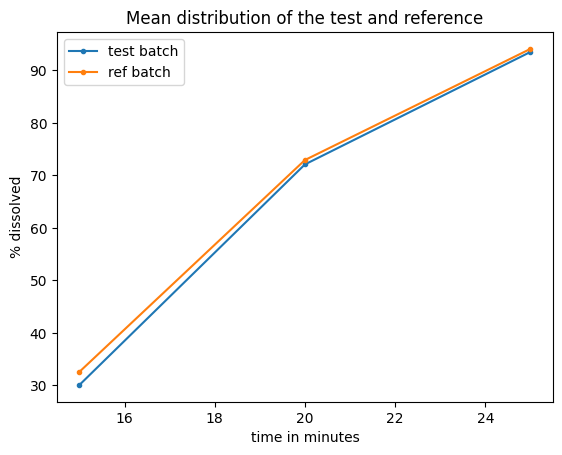


 ************************* F2 calculation *************************
Apply 85% rule? :  True
---> Include 1 time point of average dissolution >85% only
t = 25, mean of ref 94.083 & test 93.500 > 85%, preserve time 25
85% rule index list updated

Evaluate whether f2 is suitable :
* Satisfy criteria for f2: 3 time points, larger than 3
CV at first time point exceeds 20%, f2 may not be suitable
At time 20, CV exceeds 10%, f2 may not be suitable

F2 value R & T: 86.623 | bc: False | vc: False

 ******************** f2 bootstrap calculation ********************
Apply 85% rule? :  False


bootstrap 1000 samples: 100%|██████████| 1000/1000 [00:01<00:00, 537.23it/s]




                sample mean  1000 bootstraps mean        CIL       CI_U
Test batch        86.623217              66.84955  46.110951  88.896757
Test batch BCa    84.108026              66.84955  84.738518  99.555929

 ************************* MSD calculation *************************
Apply 85% rule? :  False
Mahalanobis distance (T & R): 0.23840234418661962
lower bound of DM: 0.9057339580467656
upper bound of DM: 1.3825386464200047
DM_upper | tolerance limit | conclusion
1.383 	 <=  2.248[10%]     Similar

 ************************* T square calculation *************************
Apply 85% rule? :  False
              Test statistic vs    critical value conclusion
T^2-test  | param*T2 = 0.103  <  [F_0.05] = 0.319    similar

 ************************* EDNE calculation *************************
Apply 85% rule? :  False
              Test statistic vs     critical value conclusion
EDNE Test  | T_EDNE = -5.439  <  [u_0.05] = -1.645    similar

 ************************* SE calculation *

In [ ]:
### Table 5, p = 3

new_data = dis_data([ref_df, test_df])
new_data.view_data()
new_data.plot_data()
new_data.cal_f2()
new_data.cal_bootf2()
new_data.cal_MSD(tolerance_list=[10])
new_data.cal_T_square()
new_data.cal_EDNE()
new_data.cal_SE()
new_data.cal_GMD()
print()